<h2 style="color:purple">Predictive Model Building and Performance Evaluation</h2>

## Import Dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Loading the Clean 30 mph DataFrame from CSV**

In [6]:
df_cleaned = pd.read_csv(f'data/30mph_accident_clean_data.csv', low_memory=False)

In [7]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420980 entries, 0 to 420979
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   accident_year            420980 non-null  int64  
 1   longitude                420980 non-null  float64
 2   latitude                 420980 non-null  float64
 3   accident_severity        420980 non-null  object 
 4   number_of_vehicles       420980 non-null  int64  
 5   number_of_casualties     420980 non-null  int64  
 6   date                     420980 non-null  object 
 7   day_of_week              420980 non-null  object 
 8   time                     420980 non-null  object 
 9   road_type                420980 non-null  object 
 10  junction_detail          420980 non-null  object 
 11  junction_control         420980 non-null  object 
 12  light_conditions         420980 non-null  object 
 13  weather_conditions       420980 non-null  object 
 14  road

## Feature Engineering

In [9]:
df_cleaned['casualty_vehicle_ratio'] = df_cleaned['number_of_casualties'] / df_cleaned['number_of_vehicles']

In [10]:
df_cleaned['weather_road_interaction'] = df_cleaned['weather_conditions'].astype(str) + "_" + df_cleaned['road_surface_conditions'].astype(str)

### Encoding Categorical Variables

In [12]:
df_cleaned['accident_severity'].value_counts()

accident_severity
Slight     334841
Serious     82679
Fatal        3460
Name: count, dtype: int64

In [13]:
df_cleaned['slight'].value_counts()

slight
1    334841
0     86139
Name: count, dtype: int64

### Cyclic Encoding

In [15]:
day_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_cleaned['day_of_week'] = df_cleaned['day_of_week'].map(day_map)
df_cleaned['day_of_week_sin'] = np.sin(2 * np.pi * df_cleaned['day_of_week'] / 7)
df_cleaned['day_of_week_cos'] = np.cos(2 * np.pi * df_cleaned['day_of_week'] / 7)
df_cleaned.drop('day_of_week', axis=1, inplace=True)

#### Label Encoding

In [17]:
severity_map = {'Slight':0,'Serious':1, 'Fatal':2}
light_Conditions_map = {'Daylight': 1, 'Dark_Lit': 2, 'Dark_Unknown': 3, 'Dark_unlit': 4, 'Dark_No_Light': 5}
area_map = {'Urban':-0.5, 'Rural':0.5}

In [18]:
df_cleaned['accident_severity'] = df_cleaned['accident_severity'].map(severity_map)
df_cleaned['light_conditions'] = df_cleaned['light_conditions'].map(light_Conditions_map)
df_cleaned['urban_or_rural_area'] = df_cleaned['urban_or_rural_area'].map(area_map)

#### One Hot Encoding

In [20]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['junction_control', 'junction_detail', 'road_surface_conditions',
             'road_type', 'weather_conditions', 'age_band_of_driver', 'vehicle_type', 'weather_road_interaction'], dtype=int)

In [21]:
df_cleaned.head()

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,time,light_conditions,urban_or_rural_area,...,weather_road_interaction_Windy_Rain_Dry,weather_road_interaction_Windy_Rain_Flood,weather_road_interaction_Windy_Rain_Ice,weather_road_interaction_Windy_Rain_Snow,weather_road_interaction_Windy_Rain_Wet,weather_road_interaction_Windy_Snow_Dry,weather_road_interaction_Windy_Snow_Flood,weather_road_interaction_Windy_Snow_Ice,weather_road_interaction_Windy_Snow_Snow,weather_road_interaction_Windy_Snow_Wet
0,2019,-0.153842,51.508057,0,2,3,2019-02-18,1900-01-01 17:50:00,1,-0.5,...,0,0,0,0,0,0,0,0,0,0
1,2019,-0.127949,51.436208,0,2,1,2019-01-15,1900-01-01 21:45:00,2,-0.5,...,0,0,0,0,0,0,0,0,0,0
2,2019,-0.124193,51.526795,0,2,1,2019-01-01,1900-01-01 01:50:00,2,-0.5,...,0,0,0,0,0,0,0,0,0,0
3,2019,-0.124193,51.526795,0,2,1,2019-01-01,1900-01-01 01:50:00,2,-0.5,...,0,0,0,0,0,0,0,0,0,0
4,2019,-0.200064,51.541121,0,2,2,2019-01-01,1900-01-01 00:40:00,2,-0.5,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

In [23]:
def drop_low_correlated_columns(df, threshold=0.4):
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Get the columns to drop
    columns_to_drop = []
    for i, col in enumerate(corr_matrix.columns):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                columns_to_drop.append(col)
                break

    # Drop the columns and return the modified dataframe
    return df.drop(columns=columns_to_drop, axis=1)


In [24]:
def drop_collinear_columns(df, threshold=0.8):
    # Compute the correlation matrix
    corr_matrix = df.corr().abs()

    # Create an upper triangle matrix to avoid double-counting pairs
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns to drop (where correlation exceeds the threshold)
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    # Drop the collinear columns and return the modified dataframe
    return df.drop(columns=to_drop)

### Splitting the Data into Training and Test Sets

In [26]:
X = drop_collinear_columns(drop_low_correlated_columns(df_cleaned.drop(['accident_severity', 'accident_year','date', 'time','slight'], axis=1)))
y = df_cleaned['slight']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
                                                                                                                                                                                                                    

In [27]:
y_train.value_counts()

slight
1    267873
0     68911
Name: count, dtype: int64

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336784 entries, 243589 to 108134
Data columns (total 74 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   latitude                                    336784 non-null  float64
 1   light_conditions                            336784 non-null  int64  
 2   urban_or_rural_area                         336784 non-null  float64
 3   month                                       336784 non-null  int64  
 4   day                                         336784 non-null  int64  
 5   hour                                        336784 non-null  int64  
 6   casualty_vehicle_ratio                      336784 non-null  float64
 7   day_of_week_sin                             336784 non-null  float64
 8   day_of_week_cos                             336784 non-null  float64
 9   junction_control_Authorised_Person          336784 non-null  int64  
 

### Standard Scaler

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Resampling to Handle Class Imbalance

In [32]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [33]:
y_train_resampled.value_counts()

slight
0    267873
1    267873
Name: count, dtype: int64

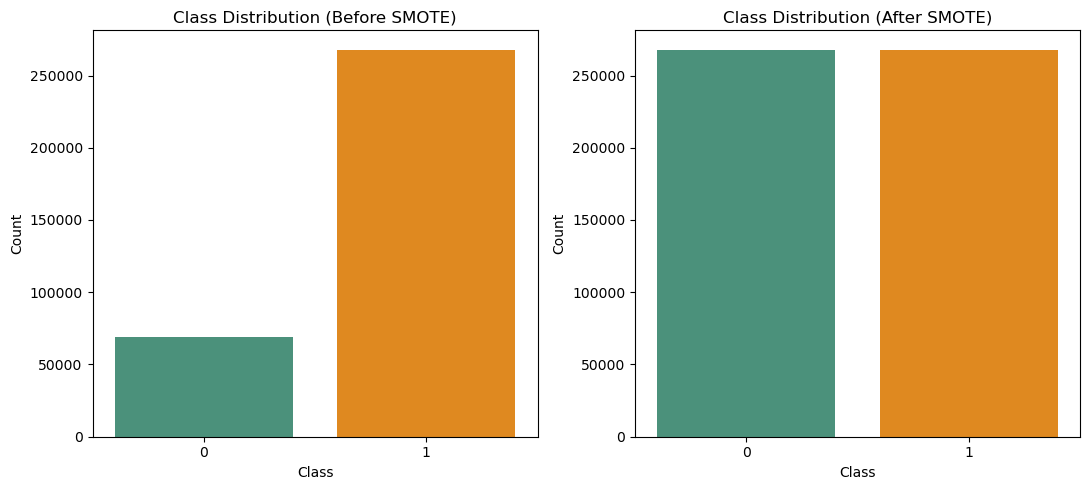

In [34]:
# Custom colors for each class
palette = {'0': '#3f9d7f', '1': '#FF8C00'}  

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Plot the distribution of classes in y_train (Before SMOTE)
sns.countplot(x=y_train, palette=palette, ax=axes[0])
axes[0].set_title("Class Distribution (Before SMOTE)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].grid(False)

# Plot the distribution of classes in y_train_resampled (After SMOTE)
sns.countplot(x=y_train_resampled, palette=palette, ax=axes[1])
axes[1].set_title("Class Distribution (After SMOTE)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].grid(False)

# Display the plots
plt.tight_layout()
plt.show()


## Building Models

In [116]:
# 1. Evaluate Model Function (metrics and confusion matrix)
def evaluate_model(model, X, y_true, y_pred):
    # Calculate Accuracy and F1-Score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Display Metrics
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=1))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='GnBu')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot AUC Curve
    plot_auc_curve(model, X, y_true, y_prob)

In [122]:
# 2. AUC (Receiver Operating Characteristic) Curve Function
def plot_auc_curve(model, X_test, y_test, y_prob):
    # Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='#15204A')
    plt.plot([0, 1], [0, 1], linestyle='--', color='#F28E2B')  # Diagonal line (random model)
    plt.title(f'ROC Curve (Model: {model.__class__.__name__})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## Bagging (Bootstrap Aggregating) Models

### Bagged Decision Tree

In [40]:
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=42)

dt_model.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Accuracy: 76.47%
F1 Score: 76.77%

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.46      0.45     17228
           1       0.86      0.84      0.85     66968

    accuracy                           0.76     84196
   macro avg       0.64      0.65      0.65     84196
weighted avg       0.77      0.76      0.77     84196



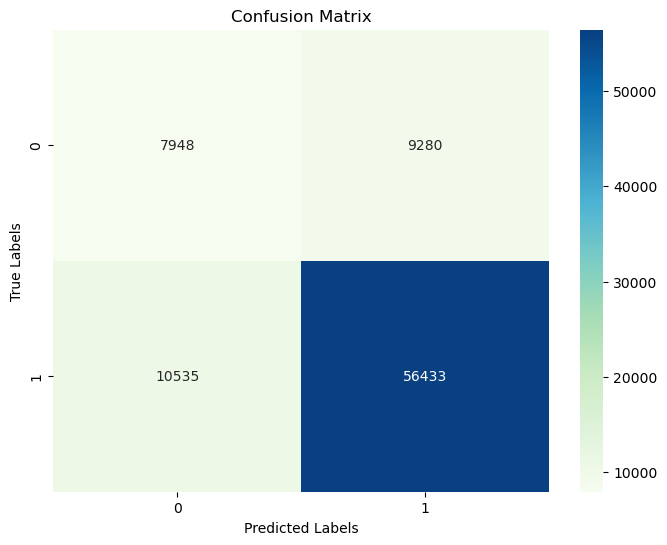

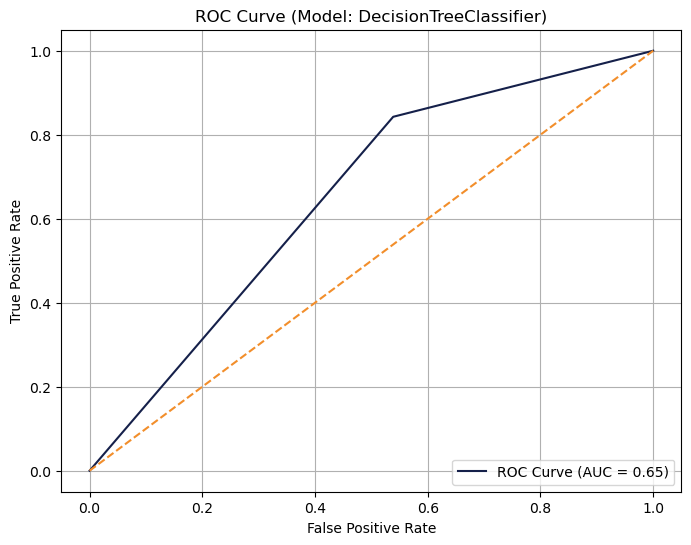

In [126]:
# Make predictions on the test data (using predict_proba for probabilities)
y_pred = dt_model.predict(X_test_scaled)
y_prob = dt_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

threshold = 0.5
y_pred_custom = (y_prob >= threshold).astype(int)

# Now evaluate with the custom thresholded predictions
evaluate_model(dt_model, X_train_resampled, y_test, y_pred_custom)

### Random Forest

In [43]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=300, random_state=42)

Accuracy: 79.95%
F1 Score: 76.05%

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.19      0.28     17228
           1       0.82      0.96      0.88     66968

    accuracy                           0.80     84196
   macro avg       0.67      0.57      0.58     84196
weighted avg       0.76      0.80      0.76     84196



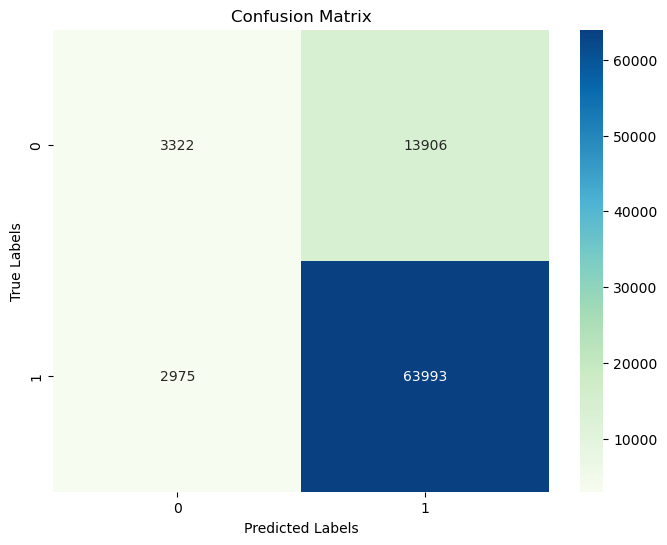

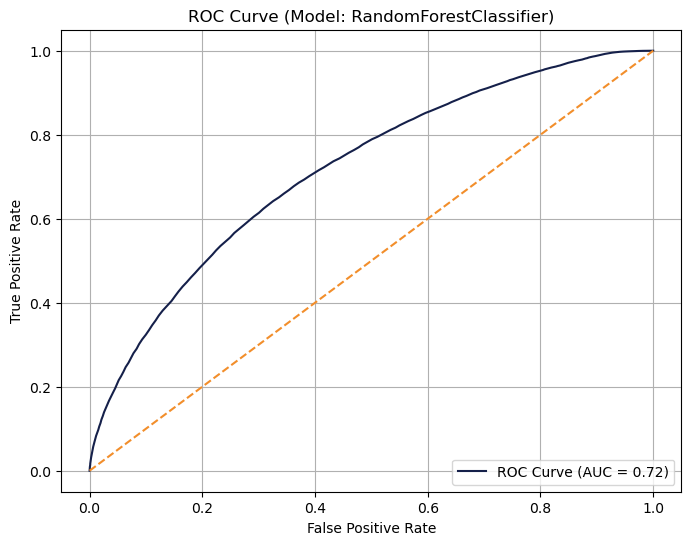

In [128]:
# Make predictions on the test data (using predict_proba for probabilities)
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

# Set a custom threshold (e.g., 0.7)
threshold = 0.5
y_pred_custom = (y_prob >= threshold).astype(int)

# Now evaluate with the custom thresholded predictions
evaluate_model(rf_model, X_train_resampled, y_test, y_pred_custom)

## Boosting Models:

### Gradient Boosting

In [47]:
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, loss='log_loss', verbose=1)
gb_model.fit(X_train_resampled, y_train_resampled)

      Iter       Train Loss   Remaining Time 
         1           1.3552            6.01m
         2           1.3216            5.93m
         3           1.3040            5.89m
         4           1.2871            5.86m
         5           1.2738            5.83m
         6           1.2628            5.82m
         7           1.2516            5.80m
         8           1.2445            5.78m
         9           1.2359            5.78m
        10           1.2285            5.77m
        20           1.1370            5.63m
        30           1.0563            5.46m
        40           0.9633            5.27m
        50           0.9089            5.07m
        60           0.8551            4.88m
        70           0.8245            4.68m
        80           0.8079            4.47m
        90           0.7831            4.26m
       100           0.7667            4.06m
       200           0.6810            2.03m
       300           0.6544            0.00s


GradientBoostingClassifier(learning_rate=0.2, n_estimators=300, verbose=1)

Accuracy: 79.61%
F1 Score: 71.68%

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.03      0.06     17228
           1       0.80      0.99      0.89     66968

    accuracy                           0.80     84196
   macro avg       0.66      0.51      0.47     84196
weighted avg       0.74      0.80      0.72     84196



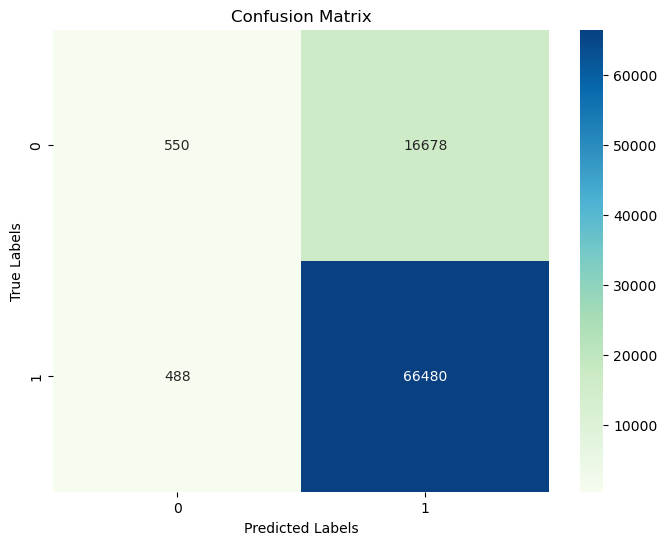

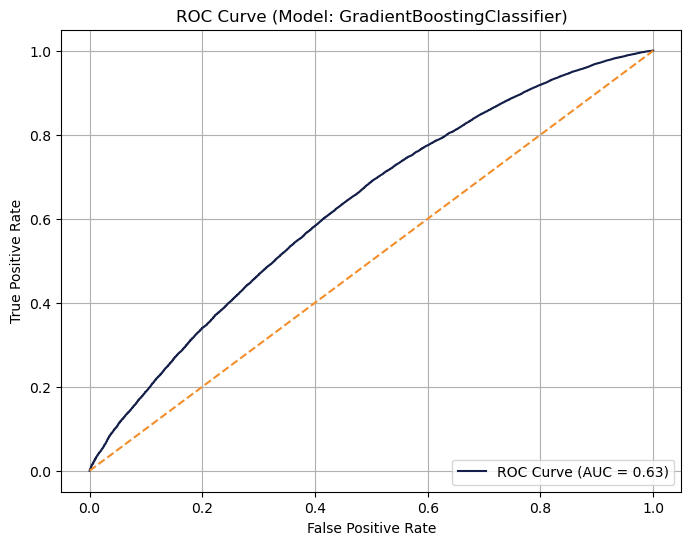

In [130]:
# Make predictions on the test data (using predict_proba for probabilities)
y_pred = gb_model.predict(X_test_scaled)
y_prob = gb_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

threshold = 0.5
y_pred_custom = (y_prob >= threshold).astype(int)

# Now evaluate with the custom thresholded predictions
evaluate_model(gb_model, X_train_resampled, y_test, y_pred_custom)

### XGBoost

In [50]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=0.5 )
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 76.95%
F1 Score: 74.30%

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.22      0.28     17228
           1       0.82      0.91      0.86     66968

    accuracy                           0.77     84196
   macro avg       0.60      0.56      0.57     84196
weighted avg       0.73      0.77      0.74     84196



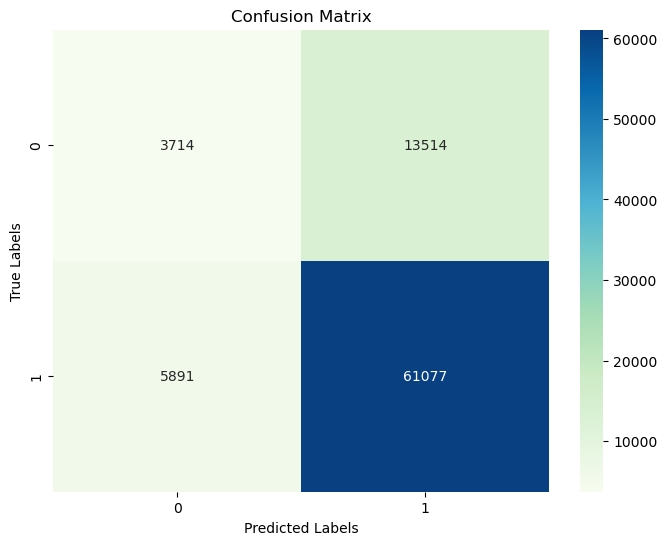

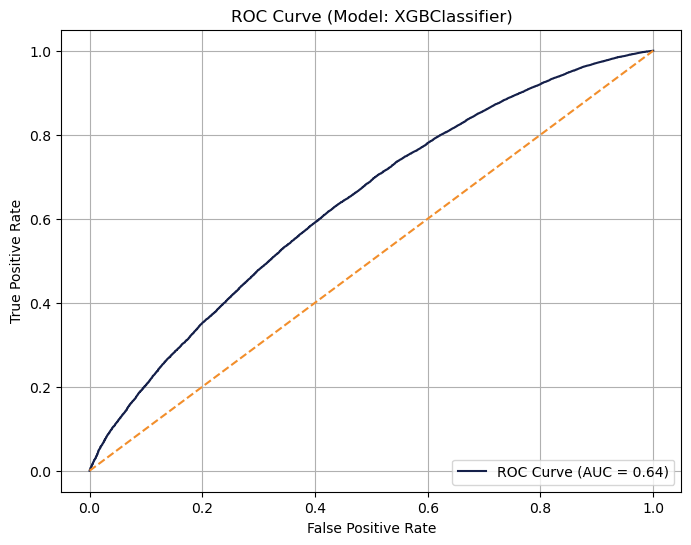

In [132]:
# Make predictions on the test data (using predict_proba for probabilities)
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

# Set a custom threshold (e.g., 0.7)
threshold = 0.5
y_pred_custom = (y_prob >= threshold).astype(int)

# Now evaluate with the custom thresholded predictions
evaluate_model(xgb_model, X_train_resampled, y_test, y_pred_custom)

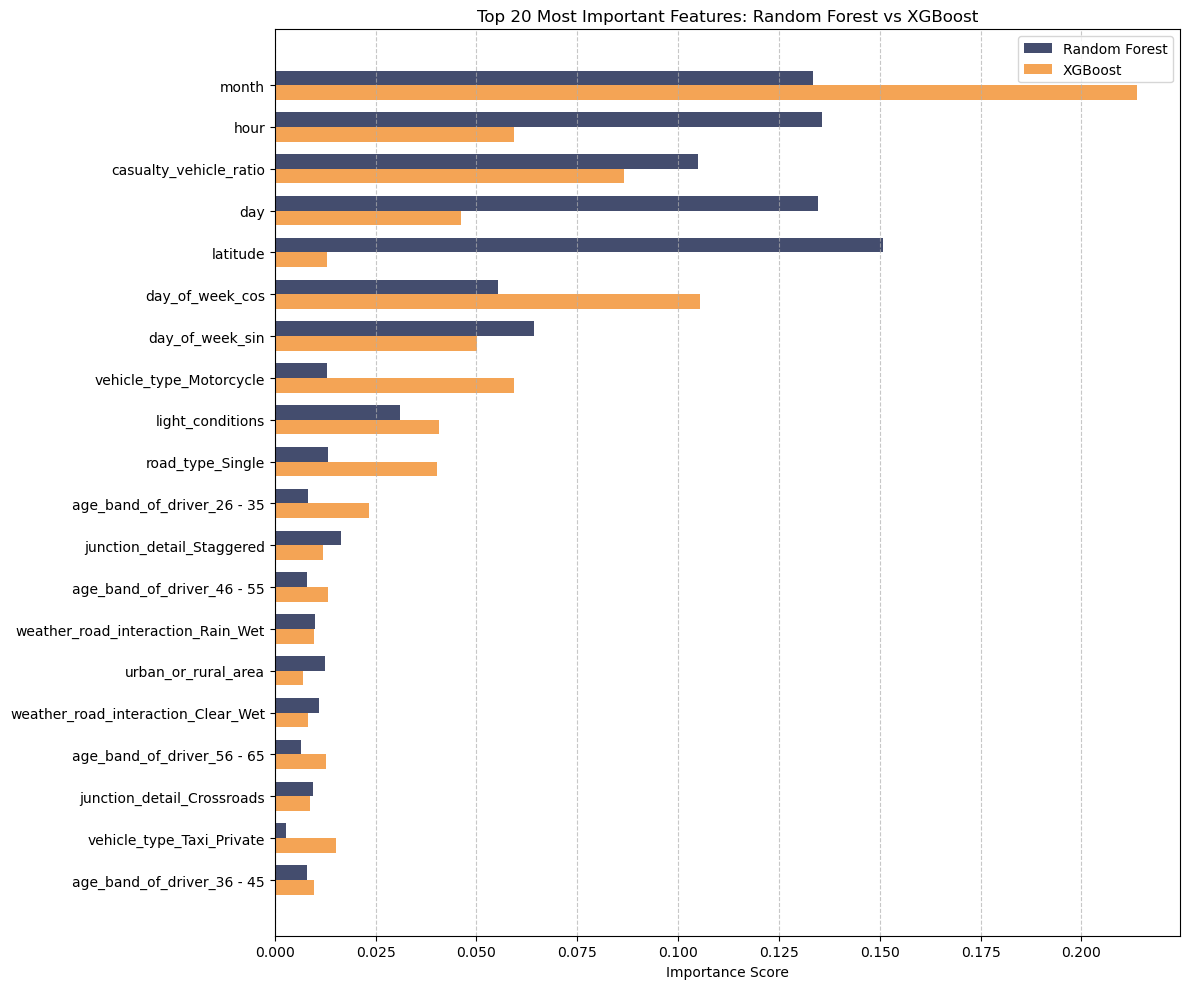

In [88]:
# Get top 20 features by average importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'RF': rf_model.feature_importances_,
    'XGB': xgb_model.feature_importances_,
    'Average': (rf_model.feature_importances_ + xgb_model.feature_importances_) / 2
})
top_20 = importance_df.nlargest(20, 'Average')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(20)
width = 0.35

# Plot bars
ax.barh(y_pos - width/2, top_20['RF'], width, 
        label='Random Forest', color='#15204A', alpha=0.8)
ax.barh(y_pos + width/2, top_20['XGB'], width,
        label='XGBoost', color='#F28E2B', alpha=0.8)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
ax.set_title('Top 20 Most Important Features: Random Forest vs XGBoost')
ax.legend()

# Add grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Save the figure
plt.savefig("feature_plot_image.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

<h2 style="color:purple">Thank You for Your Time in Reviewing This Code</h2>